# Tutorial: Coding a Variational AutoEncoder in Tensorflow


The Variational AutoEncoder network is a network architecture that aims to compress a high dimensional input vector to a vector in a lower dimensional space (encoding). In order to do so the network compresses and decompresses the input during the learning process.

![Center](images/vae_arch.png)

 We call the input of the network $X$ and the output $X'$. The train the network to obtain the optimal compression, i.e. when the difference between the input $X$ and the decompressed output $X'$ is minimum. 






***
Let's first import some useful libraries, and define the Leaky_ReLU function:

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

def lrelu(X, alpha=0.1):
    return tf.maximum(alpha*X, X)

In [2]:
import tensorflow_probability as tfp
tfd = tfp.distributions


***
Let's also import the training set

In [3]:
mnist = tf.keras.datasets.mnist
(X_train, _), (X_test, _) = mnist.load_data()

X_train = X_train.astype(np.float32).reshape(-1,28*28)/X_train.max()
X_test = X_test.astype(np.float32).reshape(-1,28*28)/X_train.max()

X_test_plot=X_test
X_train = (X_train>0.5).astype(np.float32)
X_test = (X_test>0.5).astype(np.float32)

and draw a sample


 Sample: 



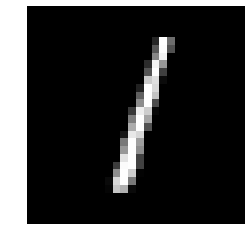

In [4]:
sample = 2 #chose one sample in the training set



print('\n Sample: \n')
plt.imshow(X_test_plot[sample].reshape(28,28), cmap='gray');
plt.axis('off');


## 1) Layer class definition

This class provides the definition of a dense layer. A dense layer is characterized by its trainable weights:

- a matrix W of dimensions (m_input, m_output)
- a bias vector b of dimensions (m_output)

The Layer class possesses the ```forward``` method which performs the linear forward propagation:

$$
Z_{out}= X_{in} \times W(m_{in},m_{out})+b(m_{out})
$$

Code along with us and follow the provided instructions:

In [5]:
class Layer(object):
    
    def __init__(self, mi, mo, name):
        
        
        self.W = tf.get_variable(name='W_'+name,        
                                 shape=(mi, mo),          
                                 initializer=tf.glorot_uniform_initializer()) 
                                                                                                               
        
        self.b = tf.get_variable(name='b_'+name, 
                                 shape=(mo,),              
                                 initializer=tf.zeros_initializer(),) 
        
    def forward(self, X):
        
        
        Z=tf.matmul(X,self.W)+self.b
        
        return Z
        
        

## 2) Creating the AutoEncoder Network

We will build the AutoEncoder as a class possessing several methods:

```
class AutoEncoder():

    def __init__():
    
    def build_network():
    
    def decode():
    
    def encode():
    
    def fit():
    
```

Code along with us and follow the provided instructions 


In [10]:
class AutoEncoder(object):
    
    def __init__(self, input_dim, layer_dims, 
                learning_rate, epochs, batch_size):
        
    
        self.layer_dims = layer_dims 
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.latent_dims = layer_dims[-1]

        #Decoder dimensions
        self.reversed_layer_dims= list(reversed(layer_dims)) 
        
        self.X_in = tf.placeholder(tf.float32, shape=(None, input_dim))
        
        
        self.encoder_layers = []
        self.decoder_layers = []
        
        self.build_network(input_dim)
        
    
    def build_network(self, input_dim):
        
        
        """
        ENCODER LAYERS
        """
        
        mi = input_dim    #input size
        count=0           
        
        for mo in self.layer_dims[:-1]:      
                                             
            
            layer = Layer(mi, mo, str(count))    
            self.encoder_layers.append(layer)
            count+=1                         
            mi = mo                          
                                             

        self.encoder_layer_mu = Layer(mi, self.latent_dims, 'encoder_mu')
        self.encoder_layer_si = Layer(mi, self.latent_dims, 'encoder_si')
        
            
        """
        DECODER LAYERS
        """

        mi = self.latent_dims
        for mo in self.reversed_layer_dims:   
            
            layer = Layer(mi, mo, str(count))      
            self.decoder_layers.append(layer) 
            count+=1                          
            mi = mo                           
            
        
        output_layer = Layer(mi,input_dim, str(count))    
        self.decoder_layers.append(output_layer)    
        
    
        """
        
        BUILDING THE GRAPH
        
        """
        #Encode the input
        self.Z_dist = self.encode(self.X_in)
        
        #get z_dist = q(z | X).sample()
        Z_dist_sample= self.Z_dist.sample()
        
        #Decode 
        logits = self.decode(Z_dist_sample)
        
        #self.X_hat_dist = tfd.Bernoulli(logits)
        self.X_hat_dist = tfd.Independent(tfd.Bernoulli(logits), 2)
        
        #get X_hat = p(X_hat | z_dist).sample()
        #self.posterior_predictive = self.X_hat_dist.sample()
        self.posterior_predictive_probs = tf.nn.sigmoid(logits)
        
        # Generate one sample
        Z_norm = tfd.MultivariateNormalDiag(loc = tf.zeros(self.latent_dims),
                                           scale_diag = tf.ones(self.latent_dims))
        
        
        logits = self.decode(Z_norm.sample(1))
        
        self.prior_predictive_probs = tf.nn.sigmoid(logits)
        
        
        self.Z_input = tf.placeholder(tf.float32, shape=(None, self.latent_dims))
        logits = self.decode(self.Z_input)
        self.prior_predictive_from_input_probs = tf.nn.sigmoid(logits) 
        
        """
        LOSS
        """
        
        # KL divergence
        kl_div = tfd.kl_divergence(self.Z_dist, Z_norm)
        print(logits.get_shape())
        print(self.X_in.get_shape())
        exp_log_likelihood = self.X_hat_dist.log_prob(self.X_in)
        
        #Expected log likelihood
        self.loss = - tf.reduce_mean(exp_log_likelihood-kl_div)
        # reduce_sum converts a tensor to a scalar sum of its components
                    
        """
        
        OPTIMIZATION ALGORITHM
        
        """
        # write code here
        self.train_op = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss)
                                                #set the learning rate                #what to minimize
        
    """
    We now define the last two functions: encode and decode which we used previously
    in STEP 2 
    """
    # write code here
    def encode(self, X):                                
                                                        
        output=X
        
        for layer in self.encoder_layers:          
                                                        
            output = layer.forward(output)              
            output = lrelu(output)

                                       
        mu = self.encoder_layer_mu.forward(output)                     
        sigma = tf.nn.softplus(self.encoder_layer_si.forward(output))+1e-6
        
        return tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)                    
        
    def decode(self,Z):                                 
                                                        
        output=Z
        
        for layer in self.decoder_layers[:-1]:               

            output = layer.forward(output)
            output = tf.nn.sigmoid(output)
            
        logits = self.decoder_layers[-1].forward(output)
        return logits
    
    
    def fit(self, X, show_fig=True):                    
         
        losses = []                                     
        n_batches = len(X) // self.batch_size
        
        print("Training AutoEncoder")
        print("n_batches:", n_batches)
        for i in range(self.epochs):
            
            print("epoch:", i)
            np.random.shuffle(X)
        
            for j in range(n_batches):                 
            
                X_batch = X[j*self.batch_size:(j+1)*self.batch_size] 
                _, l, = self.session.run((self.train_op, self.loss), 
                                         feed_dict={self.X_in: X_batch}) #running one step of gradient
                l /= self.batch_size                                     #minimization

                losses.append(l)
                
                if j % 500*self.batch_size == 0:        

                    print("iter: %d, cost: %.3f" % (j, l))
            
        if show_fig:
            plt.plot(losses)
            plt.show()


    def predict(self, X):                              # function to test the network once training
                                                       # is completed
        return self.session.run(self.posterior_predictive_probs, feed_dict={self.X_in: X})
    
    def generate_sample(self):
        
        one_sample=self.session.run(self.prior_predictive_probs)

        return one_sample
    
    def generate_sample_from_input(self, z):
        
        one_sample=self.session.run(self.prior_predictive_from_input_probs, feed_dict={self.Z_input:z})

        return one_sample
   
    def set_session(self, session):
        
        self.session = session
        

## 3) Test the AutoEncoder

Now that the AutoEncoder class is defined, we create our own AutoEncoder and test how it works. As usual follow our coding and use the provided instructions

In [11]:
_, input_dimensions = X_train.shape     # Lets get the input_dimensions from the dataset
tf.reset_default_graph()                # Resetting any previously defined graph

"""
Create the AutoEncoder object


"""
#write code here                
dae = AutoEncoder(input_dim=input_dimensions, # Create your very own network here!!
                  
                  layer_dims=[500,300,100,2],   # Play with the layers' list, it will 
                                              # automatically define the intermediate
                                              # layers.
                  learning_rate=0.001,       # Set some values for the learning rate
                  epochs=20, batch_size=100)  # the epochs and the batch_size



init_op=tf.global_variables_initializer() # Define the network's variables initializer

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.10)

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options )) as sess: #Create a tensorflow session
    
    sess.run(init_op)     # Initialize the network variables in this sess
    dae.set_session(sess) # Set it for the AutoEncoder you defined previously
    
    dae.fit(X_train)      # Call the fit method that you defined previously
    

    # Testing the created network performances on the test set!
    done = False
    while not done:
        i = np.random.choice(len(X_test))         # pick a random sample of the test set
        x = X_test[i]                             
        y = dae.predict([x]).reshape(28, 28)      # propagate it through the network

        plt.subplot(1,2,1)                        # Plot the original and the reconstructed
        plt.imshow(X_test_plot[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.subplot(1,2,2)
        plt.imshow(y, cmap='gray')
        plt.title("Reconstruction")
        plt.show()

        ans = input("Generate another?")          # Stop the while loop with 'n' or 'N'
        if ans and ans[0] in ('n' , 'N'):
              done = True
                
    done = False
    while not done:
                       
        y = dae.generate_sample();     # propagate it through the network

        plt.imshow(y.reshape(28, 28), cmap='gray');
        plt.title("Reconstruction")
        plt.show()

        ans = input("Generate another?")          # Stop the while loop with 'n' or 'N'
        if ans and ans[0] in ('n' , 'N'):
              done = True
                
#   n = 10 #number of images per side
#   x_values = np.linspace(-3,3,n)
#   y_values = np.linspace(-3,3,n)
#   
#   image = np.empty((28*n,28*n))
#   
#   Z=[]
#   for i, x in enumerate(x_values):
#       for j, y in enumerate(y_values):
#           z=[x, y]
#           Z.append(z)
#       
#   X_recon = dae.generate_sample_from_input(Z)
#   
#   k = 0
#   for i, x in enumerate(x_values):
#       for j, y in enumerate(y_values):  
#           x_recon = X_recon[k]
#           k+=1
#       
#           x_recon=x_recon.reshape(28,28)
#           image[(n - i - 1) * 28:(n - i) * 28, j * 28:(j + 1) * 28] = x_recon
#   plt.imshow(image,cmap='gray')
#   fig = plt.gcf()
#   fig.set_size_inches(10,10)
#   #fig.show()
#   #plt.show()

(?, 784)
(?, 784)
Training AutoEncoder
n_batches: 600
epoch: 0
iter: 0, cost: inf
iter: 500, cost: inf
epoch: 1
iter: 0, cost: inf
iter: 500, cost: inf
epoch: 2
iter: 0, cost: inf


KeyboardInterrupt: 